<a href="https://colab.research.google.com/github/fatimahalshehri1/MongoDB/blob/master/Part_1_DP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Part 1: Demonstration of Differential Privacy using PyDP

### About PyDP
The PyDP package provides access to Differential Privacy algorithms in Python. This example uses the 1.0 version of the package that has the following limitations:

1. This version only supports [Google's Differential Privacy library](https://github.com/google/differential-privacy).
2. Laplace noise generation technique.
3. Supports only integer and floating point values

### What's in this Tutorial
To demonstrate DP, we protect the user from something called Membership Inference Attack(MIA). 

The idea behing DP is we should **not** be able to identify the identity of an individual user.

To prove that, we are going to take a database and create two copies of it such that they differ in only one record. Or exactly one record is absent from the original Database.

#### The Proof

In this work, we have used real data from the London Data Store .project monitored from November 2011 to February 2014 the energy consumption of 5567 London households. The households were selected as a balanced sample of London’s society. Data sets were then released with the energy consumption measured every half hour, a unique household identifier, a time-stamp and energy.

 we should be able to identify which houdhold has spend how much and hence identify the user, which using the help of DP, we can avoid that. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install python-dp # installing PyDP

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pydp as dp # by convention our package is to be imported as dp (for Differential Privacy!)
from pydp.algorithms.laplacian import BoundedSum, BoundedMean, Count, Max
import pandas as pd
import statistics # for calculating mean without applying differential privacy
import numpy as np
import matplotlib.pyplot as plt

### Fetching the Data and loading it! 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

url1 = '/content/drive/MyDrive/Colab Notebooks/All/dataset/block_4.csv'
df1 = pd.read_csv(url1,sep=",", engine = "python")
df1.head()

,LCLid,tstp,energy(kWh/hh)
0,MAC000517,2012-03-27 11:30:00.0000000,0.305
1,MAC000517,2012-03-27 12:00:00.0000000,0.118
2,MAC000517,2012-03-27 12:30:00.0000000,0.214
3,MAC000517,2012-03-27 13:00:00.0000000,0.097
4,MAC000517,2012-03-27 13:30:00.0000000,0.117


#### Combining the whole data into one single dataframe. 

In [ ]:
combined_df_temp = [df1]
original_dataset = pd.concat(combined_df_temp)

In [ ]:
original_dataset['energy(kWh/hh)'] = np.where(original_dataset["energy(kWh/hh)"] == 'Null', '0',original_dataset["energy(kWh/hh)"] )

In [ ]:
ag=pd.to_numeric(list(original_dataset["energy(kWh/hh)"]))

The size of the combined dataset: 

In [ ]:
original_dataset.shape

(1473176, 3)


### Removing 1 record from the DF

Now we create our new dataset for testing DP in which we remove exactly one record from the original DB.

In [ ]:
redact_dataset = original_dataset.copy()
redact_dataset = redact_dataset[44871:] # # this dataset does not have 1consumption household(44871) 


In [ ]:
original_dataset.head()

,LCLid,tstp,energy(kWh/hh)
0,MAC000517,2012-03-27 11:30:00.0000000,0.305
1,MAC000517,2012-03-27 12:00:00.0000000,0.118
2,MAC000517,2012-03-27 12:30:00.0000000,0.214
3,MAC000517,2012-03-27 13:00:00.0000000,0.097
4,MAC000517,2012-03-27 13:30:00.0000000,0.117


In [ ]:
redact_dataset.head()

,LCLid,tstp,energy(kWh/hh)
44871,MAC000545,2013-01-20 19:00:00.0000000,0.636
44872,MAC000545,2013-01-20 19:30:00.0000000,0.647
44873,MAC000545,2013-01-20 20:00:00.0000000,0.513
44874,MAC000545,2013-01-20 20:30:00.0000000,0.484
44875,MAC000545,2013-01-20 21:00:00.0000000,0.479


In [ ]:
redact_dataset['energy(kWh/hh)'] = np.where(redact_dataset["energy(kWh/hh)"] == 'Null', '0',redact_dataset["energy(kWh/hh)"] )

In [ ]:
aj=pd.to_numeric(list(redact_dataset["energy(kWh/hh)"]))

If we find the sum of energy in `total_datset` and `redact_datset`, we should see the difference in the sum to be exactly equal to the energy consumption   .

In [ ]:
sum_original_dataset = round(sum(ag), 2)
sum_redact_dataset = round(sum(aj), 2)
energy = round((sum_original_dataset - sum_redact_dataset), 2)
energy

5519.61

It's quite evident that using the traditional methods, even though if we remove the private information like name and email, we could still infer the identity of the user. 

Using Differential Privacy, we can solve this! 

In [ ]:
string_value = str(sum_original_dataset)
print(string_value)

334956.91


In [ ]:
string_value = str(sum_redact_dataset)
print(string_value)

329437.3


In [ ]:

dp_sum_original_dataset = BoundedSum(epsilon= 1, lower_bound =0  , upper_bound = 44643, dtype ='float')

In [ ]:
original_dataset['energy(kWh/hh)'] = original_dataset['energy(kWh/hh)'].astype(float)

In [ ]:
dp_sum_og = dp_sum_original_dataset.quick_result(original_dataset['energy(kWh/hh)'].to_list()) # adding the data to the DP algorithm.to_list()

In [ ]:
dp_sum_og = round(dp_sum_og, 2)
print(dp_sum_og)

308508.84


#### Taking Sum of data on the Redacted Dataset

In [ ]:
dp_redact_dataset = BoundedSum(epsilon= 1, lower_bound =  0, upper_bound = 44643, dtype ='float')

In [ ]:
redact_dataset['energy(kWh/hh)'] = redact_dataset['energy(kWh/hh)'].astype(float)

In [ ]:
dp_redact_dataset.add_entries(redact_dataset['energy(kWh/hh)'].to_list())


In [ ]:
dp_sum_redact = round(dp_redact_dataset.result(),2)
print(dp_sum_redact)

302864.71


In [ ]:
print("Sum of sales_value in the orignal Dataset: {}".format(sum_original_dataset))
print("Sum of sales_value in the orignal Dataset using DP: {}".format(dp_sum_og))
assert dp_sum_og != sum_original_dataset


Sum of sales_value in the orignal Dataset: 334956.91
Sum of sales_value in the orignal Dataset using DP: 308508.84


In [ ]:
print("Sum of sales_value in the redacted Dataset: {}".format(sum_redact_dataset))
print("Sum of sales_value in the redacted Dataset using DP: {}".format(dp_sum_redact))
assert dp_sum_redact != sum_redact_dataset


Sum of sales_value in the redacted Dataset: 329437.3
Sum of sales_value in the redacted Dataset using DP: 302864.71


In [ ]:
print("Difference in sum using DP: {}".format(round(dp_sum_og - dp_sum_redact, 2)))
print("Actual Value: {}".format(energy))
assert round(dp_sum_og - dp_sum_redact, 2) != energy



Difference in sum using DP: 5644.13
Actual Value: 5519.61


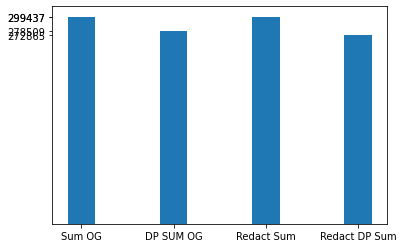

In [ ]:
take_diff = 30000
top=[('Sum OG', sum_redact_dataset - take_diff),('DP SUM OG',dp_sum_og- take_diff),('Redact Sum',sum_redact_dataset- take_diff), ('Redact DP Sum',dp_sum_redact - take_diff)]

labels, ys = zip(*top)
xs = np.arange(len(labels)) 
width = 0.3
#New_Colors = ['green','blue','purple','brown','teal']
plt.bar(xs, ys, width, align='center')

plt.xticks(xs, labels)
plt.yticks(ys)
plt.show()


### Conclusion:
We have demonstrated that using DP, as it's clearly visible, if we remove one consumption houshold from our dataset, our results do not vary a lot.